# Dictionary Learning based Beamformer

Parameters to investigate:
* Number of interferences in training vs testing
* Interferences angles in training vs testing
* Interference power in training vs testing
* Number of snapshots and training samples in training
* Input SNR
* Number of microphones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_palette
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set_palette(flatui)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.25
plt.rcParams['grid.alpha'] = 0.2
plt.style.use('seaborn-talk')

from tqdm import tnrange, tqdm_notebook
from dlbeamformer_utilities import compute_steering_vector_ULA, compute_MVDR_weight, check_distortless_constraint, uniform_linear_array, generate_gaussian_samples, generate_gaussian_training_data
from dlbeamformer import MicrophoneArray, BaseDLBeamformer
from config import sound_speed
random_seed = 0

In [2]:
# Microphone array
d = 0.5
n_mics = 10
array_geometry = uniform_linear_array(n_mics=n_mics, spacing=d)
microphone_array = MicrophoneArray(array_geometry)

# Parameters
from scipy import signal
sampling_frequency = 16000
n_samples_per_frame = 512 # frame length
hop_size = n_samples_per_frame // 2 # num_samples_per_shift
n_samples_per_overlap = n_samples_per_frame - hop_size
n_fft_bins = (int)(n_samples_per_frame / 2)
n_fft_bins_per_block = 8
n_fft_blocks = int(n_fft_bins / n_fft_bins_per_block)

azimuth_resolution_degree = 5
n_azimuth_grids = int(360 / azimuth_resolution_degree)

In [122]:
# Compute delays
tau = np.zeros((n_azimuth_grids, n_mics), dtype=np.float32)
for i_mic in range(n_mics):
    for i_azimuth in range(n_azimuth_grids):
        theta = 2*np.pi*i_azimuth/n_azimuth_grids
        tau[i_azimuth, i_mic] = i_mic * d * np.cos(theta) * sampling_frequency / sound_speed

# Compute steering vectors for each frequency bin
steering_vectors = np.zeros((n_fft_bins, n_azimuth_grids, n_mics), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    proxy = 2*np.pi*(i_fft_bin/n_samples_per_frame) * tau
#     steering_vectors[i_fft_bin] = np.exp( -1j*2*np.pi*(i_fft_bin/n_samples_per_frame) * tau )
    steering_vectors[i_fft_bin] = np.cos(proxy) - 1j * np.sin(proxy)

In [133]:
# Load data
from os import listdir
from os.path import join
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
filenames = [f for f in listdir(datapath)]
from scipy.io import wavfile
from IPython.display import Audio
sampling_frequency, source_signal = wavfile.read(join(datapath, filenames[0]))
# phi_s = np.mean(ss.dot(source_signal))
Audio(source_signal, rate=sampling_frequency)

sampling_frequency, interference_signal = wavfile.read(join(datapath, filenames[9]))

Audio(interference_signal, rate=sampling_frequency)
if len(source_signal) < len(interference_signal):
    interference_signal = interference_signal[:len(source_signal)]
else:
    source_signal = source_signal[:len(interference_signal)]
n_samples = len(source_signal)
Audio(interference_signal, rate=sampling_frequency)

In [135]:
# Compute STFT for source and interference signals
n_frames = int(np.floor(n_samples / hop_size))
stft_window_name = "hann"
stft_window = signal.get_window(stft_window_name, Nx=n_samples_per_frame)
source_stft = np.zeros((n_fft_bins, n_frames, n_mics), dtype=np.complex64)
interference_stft = np.zeros((n_fft_bins, n_frames, n_mics), dtype=np.complex64)
for i_mic in range(n_mics):
    frequency_bins, time_bins, i_mic_source_stft = signal.stft(
        source_signal, fs=sampling_frequency, window=stft_window, 
        nperseg=n_samples_per_frame, noverlap=n_samples_per_overlap, 
        nfft=n_samples_per_frame, padded=True)
    source_stft[:, :, i_mic] = i_mic_source_stft[:-1,1:-1]
    _, _, i_mic_interference_stft = signal.stft(
        interference_signal, fs=sampling_frequency, window=stft_window, 
        nperseg=n_samples_per_frame, noverlap=n_samples_per_overlap, 
        nfft=n_samples_per_frame, padded=True)
    interference_stft[:, :, i_mic] = i_mic_interference_stft[:-1,1:-1]
# i_mic_stft_db = 20*np.log10( np.abs(source_stft[:, :, 1]) / np.max(np.abs(source_stft[:, :, 1])))
# fig = plt.figure(figsize=(9, 10));
# ax = fig.add_subplot(211)
# img = ax.imshow(i_mic_stft_db, origin="lower", aspect="auto", extent=[0, time_bins[-1], 0, freq_bins[-1]/1000], cmap="RdBu_r")
# fig.colorbar(img, ax=ax, orientation="horizontal")
# ax.set_xlabel("Time [s]"); ax.set_ylabel("Frequency [KHz]"); 
# ax.set_title("Spectrogram");
# ax = fig.add_subplot(212)
# ax.plot(np.arange(n_samples)/fs, source_signal);
# ax.set_xlabel("Time [s]"); ax.set_ylabel("Amplitude"); ax.set_xlim(left=0);
# ax.set_title("Raw waveform in time")
# plt.tight_layout()

In [141]:
source_angle = 0;
i_source_angle = int(np.floor(source_angle / azimuth_resolution_degree))
interference_angle = 45
i_interference_angle = int(np.floor(interference_angle / azimuth_resolution_degree))
source_stft_multichannel = np.zeros((n_fft_bins, n_frames, n_mics), dtype=np.complex64)
interference_stft_multichannel = np.zeros((n_fft_bins, n_frames, n_mics), dtype=np.complex64)
source_steering_vectors = steering_vectors[:, i_source_angle, :].reshape(
    steering_vectors.shape[0], 1, steering_vectors.shape[2]
)
interference_steering_vectors = steering_vectors[:, i_interference_angle, :].reshape(
    steering_vectors.shape[0], 1, steering_vectors.shape[2]
)
source_stft_multichannel = source_steering_vectors * source_stft
interference_stft_multichannel = interference_steering_vectors * interference_stft
# for i_fft_bin in range(n_fft_bins):
#     i_fft_bin_source_steering_vector = steering_vectors[i_fft_bin, i_source_angle, :]
#     source_stft_multichannel[i_fft_bin, :, :] = source_stft[i_fft_bin, :, :]*i_fft_bin_source_steering_vector
# #     i_fft_bin_interference_steering_vector = steering_vectors[i_fft_bin, i_interference_angle, :]
# #     interference_stft_multichannel[i_fft_bin, :, :] = interference_stft[i_fft_bin, :, :]*i_fft_bin_interference_steering_vector
#     print(i_fft_bin)
    
received_stft_multichannel = source_stft_multichannel + interference_stft_multichannel

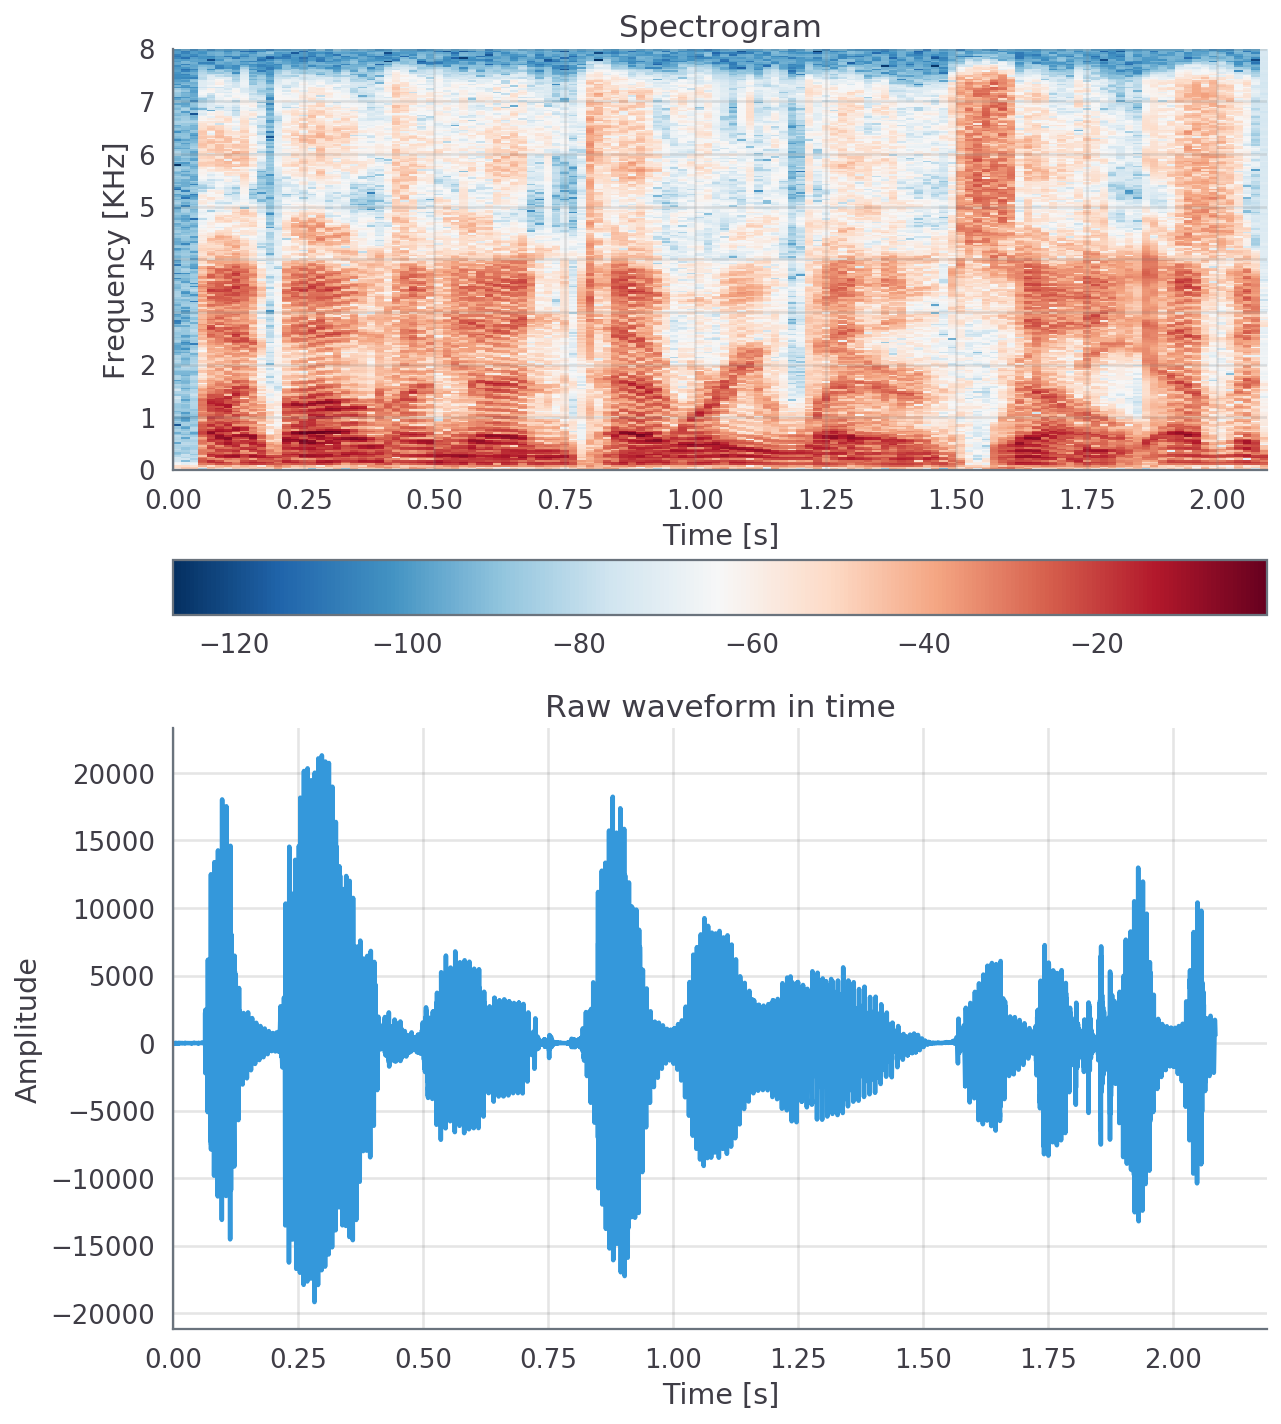

In [142]:
i_mic_stft_db = 20*np.log10( np.abs(received_stft_multichannel[:, :, 1]) / np.max(np.abs(source_stft[:, :, 1])))
fig = plt.figure(figsize=(9, 10));
ax = fig.add_subplot(211)
img = ax.imshow(i_mic_stft_db, origin="lower", aspect="auto", extent=[0, time_bins[-1], 0, frequency_bins[-1]/1000], cmap="RdBu_r")
fig.colorbar(img, ax=ax, orientation="horizontal")
ax.set_xlabel("Time [s]"); ax.set_ylabel("Frequency [KHz]"); 
ax.set_title("Spectrogram");
ax = fig.add_subplot(212)
ax.plot(np.arange(n_samples)/sampling_frequency, source_signal);
ax.set_xlabel("Time [s]"); ax.set_ylabel("Amplitude"); ax.set_xlim(left=0);
ax.set_title("Raw waveform in time")
plt.tight_layout()

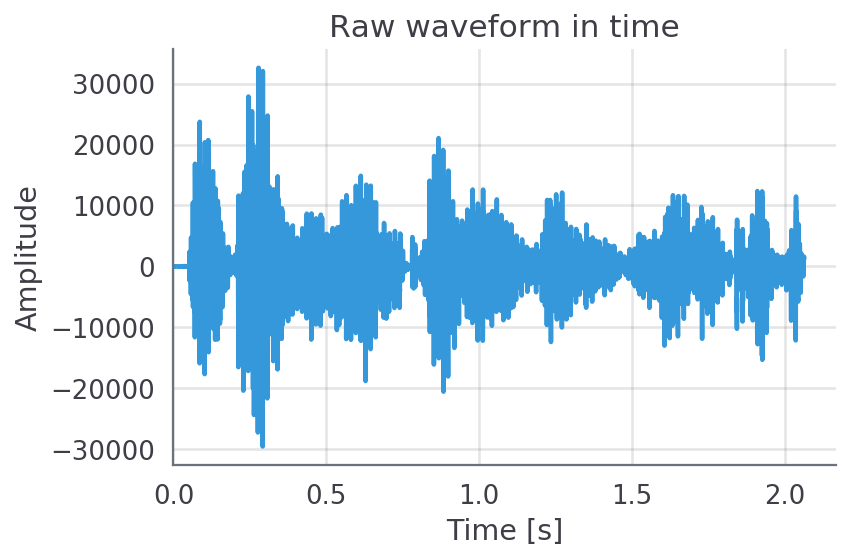

In [150]:
# Listen to the received signals at the microphones which are mixtures of the source and 
# interference signals
i_mic = 3
time_samples, received_signal_i_mic = signal.istft(received_stft_multichannel[:, :, i_mic], fs=sampling_frequency, 
                     window=stft_window, nperseg=n_samples_per_frame,
                     noverlap=n_samples_per_overlap, nfft=n_samples_per_frame)
fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(time_samples, received_signal_i_mic);
ax.set_xlabel("Time [s]"); ax.set_ylabel("Amplitude"); ax.set_xlim(left=0);
ax.set_title("Raw waveform in time")
plt.tight_layout()
Audio(received_signal_multichannel, rate=sampling_frequency)

In [156]:
# Compute spatial correlation matrices
Rii = np.zeros((n_fft_bins, n_mics, n_mics), dtype=np.complex64)
Rxx = np.zeros((n_fft_bins, n_mics, n_mics), dtype=np.complex64)
for i_fft_bin in range(n_fft_bins):
    ii = interference_stft_multichannel[i_fft_bin, :, :]
    Rii[i_fft_bin, :, :] = ii.transpose().conjugate().dot(ii)
    xx = received_stft_multichannel[i_fft_bin, :, :]
    Rxx[i_fft_bin, :, :] = xx.transpose().conjugate().dot(ii)

In [157]:
# Compute MVDR weights
mvdr_weights = np.zeros((n_fft_bins, n_mics), dtype=np.complex64)
mpdr_weights = np.zeros((n_fft_bins, n_mics), dtype=np.complex64)
source_steering_vectors.shape

(256, 1, 10)

In [ ]:
def compute_MVDR_weight(source_steering_vector, signals):
    snapshot = signals.shape[1]
    sample_covariance_matrix = signals.dot(signals.transpose().conjugate()) / snapshot
    inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
    normalization_factor = (source_steering_vector.transpose().conjugate().dot(inverse_sample_covariance_matrix).dot(source_steering_vector))
    weight = inverse_sample_covariance_matrix.dot(source_steering_vector) / normalization_factor
    return weight

In [ ]:
n_trials = 200
snapshots = np.array([10, 20, 30, 40, 60, 100, 200, 500, 1000])
n_snapshots = len(snapshots)

u_list = training_u_list
n_interferences_list = [len(u_list)]
n_interferences = len(u_list)
INR_list = [10, 20, 30, 40]
n_INRs = len(INR_list)
source_SNR = SNRs[0]

sinr_snr_mvdr = np.zeros((n_SNRs, n_INRs, n_snapshots))
sinr_snr_mpdr = np.zeros((n_SNRs, n_INRs, n_snapshots))
sinr_snr_baseline_mpdr = np.zeros((len(training_snapshots), n_SNRs, n_INRs, n_snapshots))
sinr_snr_baseline_mvdr = np.zeros((len(training_snapshots), n_SNRs, n_INRs, n_snapshots))

for i_SNR in tqdm_notebook(range(n_SNRs), desc="SNR"):
    source_SNR = SNRs[i_SNR]
    sigma_s = 10**(source_SNR / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())
    
    for i_INR in tqdm_notebook(range(n_INRs), desc="INR"):        
        interference_power = INR_list[i_INR]
        
        for i_snapshot in tqdm_notebook(range(n_snapshots), desc="Snapshots", leave=False):
            snapshot = snapshots[i_snapshot]
            sinr_mvdr = np.zeros(n_trials)
            sinr_mpdr = np.zeros(n_trials)
            sinr_baseline_mpdr = np.zeros((len(training_snapshots), n_trials))
            sinr_baseline_mvdr = np.zeros((len(training_snapshots), n_trials))

            for i_trial in range(n_trials):
                ss = np.sqrt(sigma_s/2)*np.random.randn(1, snapshot) + 1j*np.sqrt(sigma_s/2)*np.random.randn(1, snapshot) # signal samples            
                nn = np.sqrt(noise_sigma/2)*np.random.randn(microphone_array.n_mics, snapshot) + 1j*np.sqrt(noise_sigma/2)*np.random.randn(microphone_array.n_mics, snapshot) # Gaussian noise samples
                
                nv = np.zeros((microphone_array.n_mics, snapshot), dtype=complex)
                Rn = np.zeros((microphone_array.n_mics, microphone_array.n_mics), dtype=complex)
                for i_interference in range(n_interferences):
                    u = u_list[i_interference]                
                    sigma = 10**(interference_power/10)     
                    ii = generate_gaussian_samples(power=sigma, shape=(1, snapshot))
                    interference_steering_vector = compute_steering_vector_ULA(u, microphone_array)
                    nv += interference_steering_vector*ii
                    Rn += sigma*interference_steering_vector.dot(interference_steering_vector.transpose().conjugate())
                nv += nn
                Rn += noise_sigma*np.identity(microphone_array.n_mics)
                Rninv = np.linalg.inv(Rn)

                sv = vs*ss
                xx = sv + nv

                for i_dictionary in range(len(dictionaries)):
                    dictionary = dictionaries[i_dictionary]
                    w_baseline_p = dictionary.choose_weights(xx)
                    sinr_baseline_mpdr[i_dictionary, i_trial] = np.real(w_baseline_p.transpose().conjugate().dot(Rs).dot(w_baseline_p)) / np.real(w_baseline_p.transpose().conjugate().dot(Rn).dot(w_baseline_p))
                    w_baseline_v = dictionary.choose_weights(nv)
                    sinr_baseline_mvdr[i_dictionary, i_trial] = np.real(w_baseline_v.transpose().conjugate().dot(Rs).dot(w_baseline_v)) / np.real(w_baseline_v.transpose().conjugate().dot(Rn).dot(w_baseline_v))                            
                    check_distortless_constraint(w_baseline_p, vs)
                    check_distortless_constraint(w_baseline_v, vs)
                wv = compute_MVDR_weight(vs, nv)
                wp = compute_MVDR_weight(vs, xx)

                check_distortless_constraint(wv, vs)
                check_distortless_constraint(wp, vs)

                sinr_mvdr[i_trial] = np.real(wv.transpose().conjugate().dot(Rs).dot(wv)) / np.real(wv.transpose().conjugate().dot(Rn).dot(wv))
                sinr_mpdr[i_trial] = np.real(wp.transpose().conjugate().dot(Rs).dot(wp)) / np.real(wp.transpose().conjugate().dot(Rn).dot(wp))
            
            sinr_snr_mvdr[i_SNR, i_INR, i_snapshot] = np.sum(sinr_mvdr) / n_trials
            sinr_snr_mpdr[i_SNR, i_INR, i_snapshot] = np.sum(sinr_mpdr) / n_trials

            for i_dictionary in range(len(dictionaries)):
                sinr_snr_baseline_mpdr[i_dictionary, i_SNR, i_INR, i_snapshot] = np.sum(sinr_baseline_mpdr[i_dictionary, :]) / n_trials
                sinr_snr_baseline_mvdr[i_dictionary, i_SNR, i_INR, i_snapshot] = np.sum(sinr_baseline_mvdr[i_dictionary, :]) / n_trials

##### Dependence of Baseline DLBeamformer on the input SNR

When the interferences are fixed, the MPDR DLBeamformer using the received data samples performs worse as the source gets stronger. This might be due to the fact that the input source in $received \ data = source + interference + noise$ dominates other elements which in turns confuses the MPDR DLBeamformer. In the figure below, the gap between MPDR DLBeamformer and MVDR DLBeamformer gets bigger as the input SNR increases.

In [ ]:
print("Number of training snapshots: {}".format(training_snapshots[0]))
from matplotlib.figure import figaspect
w, h = figaspect(9/16)
for i_INR in range(n_INRs):
    fig = plt.figure(figsize=(w*n_SNRs, h));
    for i_SNR in range(n_SNRs):
        ax = fig.add_subplot(1, n_SNRs, i_SNR+1)
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_mpdr[i_SNR, i_INR, :]), marker="o", alpha=0.3, label="MPDR")
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_mvdr[i_SNR, i_INR, :]), marker="*", alpha=0.3, label="MVDR")
        for i_training_snapshot in range(len(training_snapshots)):
            ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, i_INR, :]), 
                        label="Baseline DL MPDR")
            ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, i_INR, :]), 
                        label="Baseline DL MVDR")
            ax.fill_between(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, i_INR, :]),
                                       10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, i_INR, :]), color='0.8')
        ax.legend()
        ax.set_xlim(10, 1000); ax.set_ylim(-10, 45);
        ax.set_xlabel("Number of testing snapshots");
        ax.set_ylabel(r"$SINR_0$ [dB]");
        ax.set_title("Input SNR = {} dB, input INR = {} dB".format(SNRs[i_SNR], INR_list[i_INR]))
    plt.tight_layout()    
    # fig.savefig("baseline_dl_various_interferences.jpg", dpi=600)    

##### Dependence of Baseline DLBeamformer on the interference INRs
When the input SNR is fixed, the Baseline DLBeamformer works worse as the input interferences get stronger. In the figures below, the gap between MVDR DLBeamformer vs Optimal MVDR Beamformer becomes larger when the input interferences are more severe.

In [ ]:
print("Number of training snapshots: {}".format(training_snapshots[0]))
from matplotlib.figure import figaspect
w, h = figaspect(9/16)
for i_SNR in range(n_SNRs):
    fig = plt.figure(figsize=(w*n_INRs, h));
    for i_INR in range(n_INRs):
        ax = fig.add_subplot(1, n_INRs, i_INR+1)
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_mpdr[i_SNR, i_INR, :]), marker="o", alpha=0.3, label="MPDR")
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_mvdr[i_SNR, i_INR, :]), marker="*", label="MVDR")
        for i_training_snapshot in range(len(training_snapshots)):
            ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, i_INR, :]), 
                        label="Baseline DL MPDR")
            ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, i_INR, :]), 
                        label="Baseline DL MVDR")
            ax.fill_between(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, i_INR, :]),
                                       10*np.log10(sinr_snr_mvdr[i_SNR, i_INR, :]), color='0.8')
        ax.legend()
        ax.set_xlim(10, 1000); ax.set_ylim(-10, 45);
        ax.set_xlabel("Number of testing snapshots");
        ax.set_ylabel(r"$SINR_0$ [dB]");
        ax.set_title("Input SNR = {} dB, input INR = {} dB".format(SNRs[i_SNR], INR_list[i_INR]))
    plt.tight_layout()    
    # fig.savefig("baseline_dl_various_interferences.jpg", dpi=600)    

In [ ]:
v = np.array([1,2,3])  # v has shape (3,)
w = np.array([4,5])    # w has shape (2,)
np.reshape(v, (3, 1))*w